# <center>National Anthem Clustering</center>

## Modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt


from sklearn import cluster
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_samples, silhouette_score

import re
import nltk
import nltk.corpus
from unidecode import unidecode
from wordcloud import WordCloud
from nltk import SnowballStemmer
from nltk.tokenize import word_tokenize


import json
import folium
import warnings
import geopandas as gpdf
import branca.colormap as cm
from branca.element import Figure



%matplotlib inline
nltk.download('punkt')
nltk.download('stopwords')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\samra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Initialize dataframe

In [2]:
df = pd.read_csv('./assets/anthems.csv', encoding='utf-8')
df.columns = map(str.lower, df.columns)
df.head()

,country,alpha-2,alpha-3,continent,anthem
0,Albania,AL,ALB,Europe,"Around our flag we stand united, With one wish..."
1,Armenia,AM,ARM,Europe,"Our Fatherland, free, independent, That has fo..."
2,Austria,AT,AUT,Europe,"Land of mountains, land by the river, Land of ..."
3,Azerbaijan,AZ,AZE,Europe,"Azerbaijan, Azerbaijan! The glorious Fatherlan..."
4,Belarus,BY,BLR,Europe,"We, Belarusians, are peaceful people, Wholehea..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   country    190 non-null    object
 1   alpha-2    189 non-null    object
 2   alpha-3    190 non-null    object
 3   continent  190 non-null    object
 4   anthem     190 non-null    object
dtypes: object(5)
memory usage: 7.6+ KB


In [4]:
df.describe()

,country,alpha-2,alpha-3,continent,anthem
count,190,189,190,190,190
unique,190,188,190,6,188
top,Albania,CH,ALB,Africa,"Arise, ye who refuse to be slaves; With our ve..."
freq,1,2,1,56,2


In [5]:
df.isnull().sum()

country      0
alpha-2      1
alpha-3      0
continent    0
anthem       0
dtype: int64

In [6]:
df.loc[df['alpha-2'].isnull()]

,country,alpha-2,alpha-3,continent,anthem
168,Namibia,NaN,NAM,Africa,Namibia land of the brave Freedom fight we he ...


Now, setting the alpha-2 country code of Namibia to 'NA'.

In [7]:
df.loc[df['country'] == 'Namibia', ['alpha-2']] = 'NA'

In [8]:
df.isnull().sum()

country      0
alpha-2      0
alpha-3      0
continent    0
anthem       0
dtype: int64

## Data preprocessing

In [9]:
anthem_corpus = df['anthem'].tolist()

In [10]:
df.loc[df['country'] == 'Nepal']

,country,alpha-2,alpha-3,continent,anthem
114,Nepal,NP,NPL,Asia,"Woven from hundreds of flowers, we are one gar..."


In [11]:
anthem_corpus[114]

"Woven from hundreds of flowers, we are one garland that's Nepali Spread sovereign from Mechi to Mahakali. A shawl of nature's wealth unending From the blood of the braves, a nation free and non-moving. A land of knowledge, of peace, the plains, hills and mountains tall Indivisible, this beloved land of ours, our motherland Nepal. Of many races, languages, religions, and cultures of incredible sprawl This progressive nation of ours, all hail Nepal!"

#### Manipulating the corpus

**Remove stopwords (a, an, the, etc) from the list**  
A token refers to a grouping of characters within a specific document, forming a meaningful semantic unit for processing. We are tokenizing words with spaces.

**Stemming each word**  
Stemming is a process used to reduce words to their base or root form and is done by removing prefix or suffix from words. Eg: running -> run and happily -> happi.

**Remove any words composed of less than 2 or more than 2 letters**

In [12]:
def removeWords(tokenList, wordList):
    return [token for token in tokenList if token not in wordList]

def stemWords(tokenList, stemmer):
    return [stemmer.stem(token) for token in tokenList]

def removeExtremeWords(tokenList):
    return [ word for word in tokenList if (len(word) > 2 and len(word) <21) ]

In [13]:
def prepareCorpus(corpus, language):
    stopwords = nltk.corpus.stopwords.words(language)
    paramStemmer = SnowballStemmer(language)
    
    countryList = [line.rstrip('\n') for line in open('./assets/countries.txt')]
    nationalityList = [line.rstrip('\n') for line in open('./assets/nationalities.txt')]
    otherWordsList = [line.rstrip('\n') for line in open('./assets/stopwords.txt')]

    for index, single_doc in enumerate(corpus):

        # remove ASCII '�' symbols with '8'
        corpus[index] = corpus[index]. replace(u'\ufffd', '8')
        # remove commas
        corpus[index] = corpus[index]. replace(',', '')
        # remove line breaks
        corpus[index] = corpus[index]. rstrip('\n')
        # make all letters to lowercase
        corpus[index] = corpus[index].casefold()
        # remove special characters
        corpus[index] = re.sub('\W_', ' ', corpus[index])
        # remove numbers concatenated with letters
        corpus[index] = re.sub('\S*\dS*', ' ', corpus[index])
        # remove words with @
        corpus[index] = re.sub('\S*@\S*s?', ' ', corpus[index])
        # remove URLs with http
        corpus[index] = re.sub(r'http\S+', '', corpus[index])
        # removes URLs with www
        corpus[index] = re.sub(r'www\S+', '', corpus[index])

        # tokenize (seperate the words)
        tokenizedWords = word_tokenize(corpus[index])

        tokenizedWords = removeWords(tokenizedWords, stopwords)
        tokenizedWords = removeExtremeWords(tokenizedWords)
        tokenizedWords = removeWords(tokenizedWords, countryList)
        tokenizedWords = removeWords(tokenizedWords, nationalityList)
        tokenizedWords = removeWords(tokenizedWords, otherWordsList)
        tokenizedWords = stemWords(tokenizedWords, paramStemmer)
        tokenizedWords = removeWords(tokenizedWords, otherWordsList)

        corpus[index] = " ".join(tokenizedWords)
        corpus[index] = unidecode(corpus[index])
        
        

    return corpus

In [14]:
language = 'english'
corpus = prepareCorpus(anthem_corpus, language)

In [15]:
corpus[114]

'woven hundr flower garland nepali spread sovereign mechi mahakali shawl natur wealth unend blood brave nation free non-mov land knowledg peac plain hill mountain tall indivis belov land motherland nepal race languag religion cultur incred sprawl progress nation hail nepal'

### Feature Engineering to convert text to number

In [16]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
final_df = pd.DataFrame(data=X.toarray(), columns=vectorizer.get_feature_names_out())
# get_feature_names_out() returns the word

In [17]:
final_df.T.nlargest(5, 0)

,0,1,2,3,4,5,6,7,8,9,...,180,181,182,183,184,185,186,187,188,189
albania,0.327370,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
sacr,0.296967,0.000000,0.000000,0.000000,0.091121,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
fatherland,0.240788,0.115536,0.070006,0.158262,0.000000,0.082113,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
proclaim,0.232592,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.111648
flag,0.208506,0.100047,0.000000,0.045681,0.063978,0.000000,0.0,0.0,0.0,0.0,...,0.090161,0.0,0.0,0.0,0.0,0.063262,0.0,0.0,0.045012,0.066724


### Model Training

In [18]:
def trainKMeans(data, kmax):
    kmeans_result = dict()

    for k in range(2, kmax+1): # min 2 clusters
        kmeans = cluster.KMeans(n_clusters=k, 
                                init='k-means++', 
                                n_init=10, 
                                tol=0.0001,
                                random_state=1,
                                algorithm='full')

        kmeans_result.update({k: kmeans.fit(data)})

    return kmeans_result

In [19]:
k = 5
kmeans_result = trainKMeans(final_df, k)

### Cluster Analysis

Now we can choose the best number of K and take a deeper look at each cluster. Looking at the plots above, we have some clues that when K = 5 is when the clusters are best defined. So first we will use a simple histogram to look at the most dominant words in each cluster:

In [20]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    df_list = []

    for label in labels:
        id = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names_out()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        individual_df = pd.DataFrame(best_features, columns = ['features', 'score'])
        df_list.append(individual_df)

    return df_list

def plotWords(df_list, n_feats):
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    
    fig.suptitle('Most Common Words in each cluster', fontsize=20, fontweight='bold')
    axes[-1, -1].axis('off')
    ax = axes.flat

    for i in range(0, len(df_list)):
        # print(df_list[i][:n_feats]['features'])
        sns.barplot(x='score', y='features', orient='h', data=df_list[i][:n_feats], palette='dark', ax=ax[i])
        ax[i].set(title=f"Cluster {i}")
        ax[i].set(xticklabels=[])
        ax[i].set(xlabel=None)
        ax[i].set(ylabel=None)

    plt.tight_layout()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)
    
    plt.show()

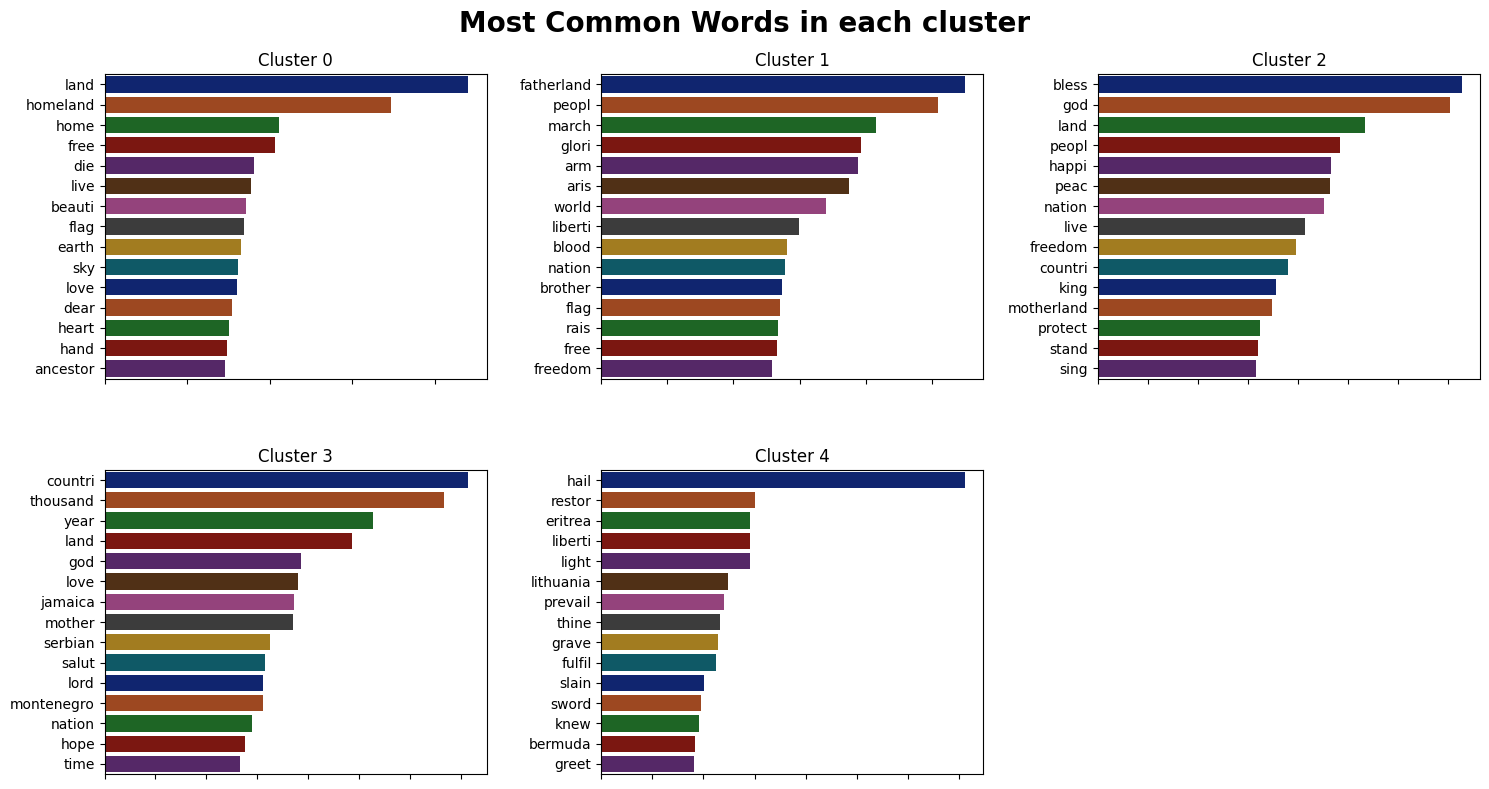

In [21]:
best_results = 5
kmeans = kmeans_result.get(best_results)

final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
df_list = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(df_list, 15)

### WordCloud Visualization

In [22]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()
    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )
        
    return centroid_dict
    

def generateWordClouds(centroids):
    wordcloud = WordCloud()
    fig, axes = plt.subplots(2, 3, figsize=(13, 7))
    
    fig.suptitle('Word Cloud Map', fontsize=20, fontweight='bold')
    axes[-1, -1].axis('off')
    ax = axes.ravel()

    for i in range(0, len(df_list)): 
        centroid_dict = centroidsDict(centroids, i)
        wordcloud.generate_from_frequencies(centroid_dict)
        ax[i].set(title=f'Cluster {i}')
        ax[i].imshow(wordcloud, interpolation='bilinear')
        ax[i].axis("off")

    plt.tight_layout()
    plt.show()

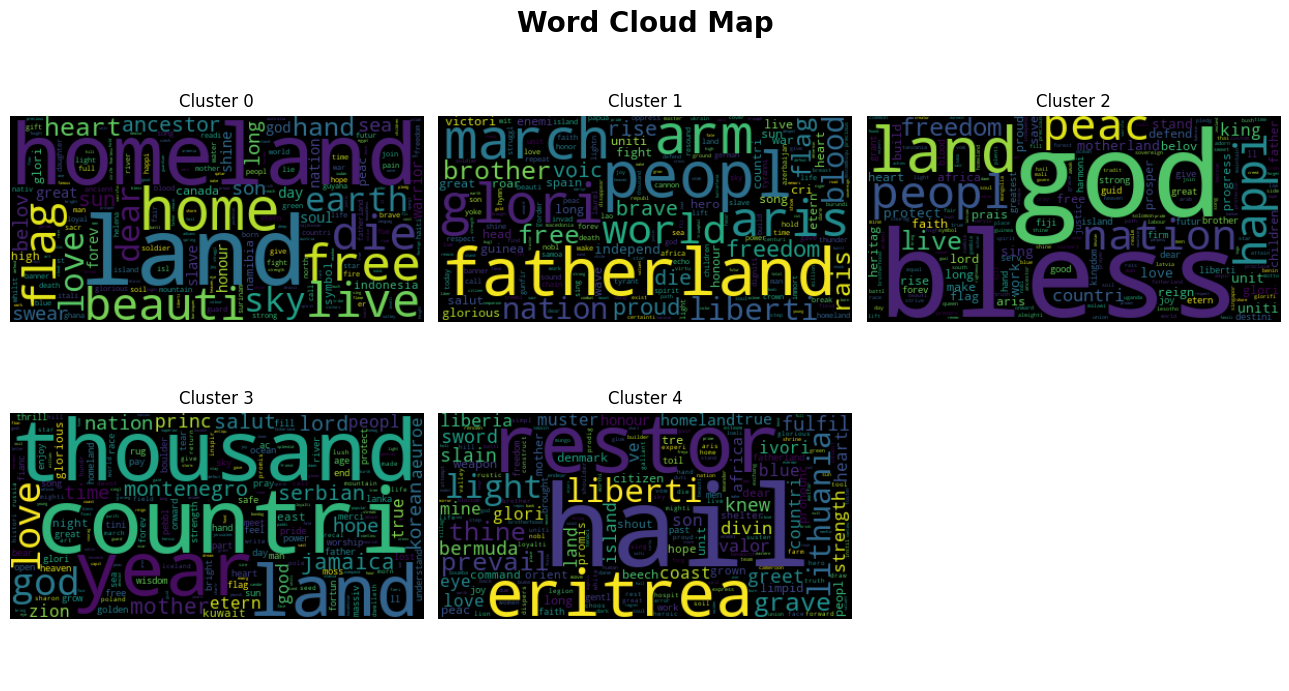

In [23]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)

In [25]:
labels = kmeans.labels_ 
df['label'] = labels
df.head()

,country,alpha-2,alpha-3,continent,anthem,label
0,Albania,AL,ALB,Europe,"Around our flag we stand united, With one wish...",0
1,Armenia,AM,ARM,Europe,"Our Fatherland, free, independent, That has fo...",0
2,Austria,AT,AUT,Europe,"Land of mountains, land by the river, Land of ...",0
3,Azerbaijan,AZ,AZE,Europe,"Azerbaijan, Azerbaijan! The glorious Fatherlan...",1
4,Belarus,BY,BLR,Europe,"We, Belarusians, are peaceful people, Wholehea...",2


In [26]:
df['label'].value_counts().sort_values()

label
4    12
3    22
0    44
1    49
2    63
Name: count, dtype: int64

In [27]:
df['label_name'] = np.nan
df.loc[df['label']==0, 'label_name'] = 'Sentiments of Home'
df.loc[df['label']==1, 'label_name'] = 'Glory of the Fatherland'
df.loc[df['label']==2, 'label_name'] = 'Harmony and Freedom'
df.loc[df['label']==3, 'label_name'] = 'Timeless Love'
df.loc[df['label']==4, 'label_name'] = 'Liberty and Light'

### Visualization using the world map

In [31]:
geo_path = './assets/world-countries.json'
geography = json.load(open(geo_path))
gdf = gpd.read_file(geo_path)

# merging on alpha-3 country codes
merge = pd.merge(gdf, df, left_on='id', right_on='alpha-3')

map_df = merge[['id', 'name', 'label', 'label_name', 'geometry']]
map_df.head()

,id,name,label,label_name,geometry
0,AFG,Afghanistan,0,Sentiments of Home,"POLYGON ((61.21082 35.65007, 62.23065 35.27066..."
1,AGO,Angola,1,Glory of the Fatherland,"MULTIPOLYGON (((16.32653 -5.87747, 16.57318 -6..."
2,ALB,Albania,0,Sentiments of Home,"POLYGON ((20.59025 41.85540, 20.46317 41.51509..."
3,ARE,United Arab Emirates,2,Harmony and Freedom,"POLYGON ((51.57952 24.24550, 51.75744 24.29407..."
4,ARG,Argentina,1,Glory of the Fatherland,"MULTIPOLYGON (((-65.50000 -55.20000, -66.45000..."


In [32]:
map_df.loc[map_df['name'] == 'Nepal']

,id,name,label,label_name,geometry
113,NPL,Nepal,2,Harmony and Freedom,"POLYGON ((88.12044 27.87654, 88.04313 27.44582..."


In [93]:
values = map_df[['label']].to_numpy()
color_palette = cm.StepColormap(['green', 'blue', 'red', 'magenta', 'yellow'],
                               vmin=values.min(), vmax=values.max(), caption='palette')
color_palette

In [63]:
def make_geojson_choropleth(display, data, colors):
    group_dict = data.set_index('id')['label']
    tooltip = folium.features.GeoJsonTooltip(['name', 'label_name'], aliases=display, labels=True)

    return folium.GeoJson(data[["id", "name", "label_name", "geometry"]],
                          style_function = lambda feature: {
                              'fillColor': colors(group_dict[feature['properties']['id']]),
                               'color':'black',
                               'weight':0.5},
                          highlight_function = lambda x: {'weight':2, 'color':'black'},
                          smooth_factor=2.0,
                          tooltip = tooltip)

In [64]:
def display(map, width, height):
    fig = Figure(width=width, height=height)
    fig.add_child(map)

In [94]:
map = folium.Map(location=[43.5775, -10.106111], zoom_start=2.3, tiles='cartodbpositron')
geojson_choropleth = make_geojson_choropleth(["Country:", "Group:"], map_df, color_palette)
geojson_choropleth.add_to(map)

width, height = 1300, 675
display(map, width, height)

In [95]:
map